# Sentiment Analysis

<br>

We are using [this](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student)
 model from Hugging Face

### Install the transformers library

In [ ]:
!pip install datasets transformers==4.28.0
!pip install --upgrade accelerate
!pip install torchvision 

<br>

## Importing packages 

In [1]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

<br>

## Class for Data Preparation

In [2]:
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

# Load tokenizer and model, create trainer

In [3]:
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

<br>
<br>

# Testing the Model

<hr>

In [4]:
pred_texts = ['No hike in basic exemption, no increase in deductions, not even a change in tax slabs– why should taxpayers feel happy about the interim Budget announced last week','That is annoying','This is great!','Wouldn´t recommend it.']

In [5]:
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [6]:
predictions = trainer.predict(pred_dataset)

In [7]:
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [8]:
df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores)), columns=['text','pred','label','score'])
df.head()

,text,pred,label,score
0,"No hike in basic exemption, no increase in ded...",0,NEGATIVE,0.999482
1,That is annoying,0,NEGATIVE,0.999409
2,This is great!,1,POSITIVE,0.998727
3,Wouldn´t recommend it.,0,NEGATIVE,0.999486


<br>
<br>

# Scrapping the Web for Data

<hr>


As we can see, our model takes input of a sentence to find the sentiment it shows. <br>
Thus we need to extract the data split the sentence and store it into a set.

In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
url = 'https://economictimes.indiatimes.com/wealth/tax/what-budget-2024-means-for-you-positive-takeaways-from-the-interim-budget/articleshow/107377274.cms?from=mdr'
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
target_element = soup.find(class_='artText')
text = target_element.get_text()
text

'No hike in basic exemption, no increase in deductions, not even a change in tax slabs– why should taxpayers feel happy about the interim Budget announced last week? Let us enumerate the reasons. For one, the government has extended an olive branch to taxpayers stuck with petty tax demands of previous years. The Budget has proposed to withdraw all direct tax demands up to Rs.25,000 till the year 2009-10 and up to Rs.10,000 for the years 2010-11 to 2014-15.The move is expected to benefit an estimated 1 crore taxpayers, who are still disputing these tax demands. It will not only free them from the tussle with the taxman, but also pave the way for tax refunds that were held up due to pending tax demands. Rajarshi Dasgupta, Executive Director and National Head of Tax, AQUILAW, observed, “In case of a pending tax demand, any refund in the subsequent year is not processed unless such demand is addressed. By disposing of the demands, many refund claims will be expedited.”The proposal comes at

## Creating function to split paragraph into sentences

In [11]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"
multiple_dots = r'\.{2,}'

def split_into_sentences(text: str) -> list[str]:
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(multiple_dots, lambda match: "<prd>" * len(match.group(0)) + "<stop>", text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = [s.strip() for s in sentences]
    if sentences and not sentences[-1]: sentences = sentences[:-1]
    return sentences

In [12]:
text_to_analysis = split_into_sentences(text)
text_to_analysis

['No hike in basic exemption, no increase in deductions, not even a change in tax slabs– why should taxpayers feel happy about the interim Budget announced last week?',
 'Let us enumerate the reasons.',
 'For one, the government has extended an olive branch to taxpayers stuck with petty tax demands of previous years.',
 'The Budget has proposed to withdraw all direct tax demands up to Rs.',
 '25,000 till the year 2009-10 and up to Rs.',
 '10,000 for the years 2010-11 to 2014-15.',
 'The move is expected to benefit an estimated 1 crore taxpayers, who are still disputing these tax demands.',
 'It will not only free them from the tussle with the taxman, but also pave the way for tax refunds that were held up due to pending tax demands.',
 'Rajarshi Dasgupta, Executive Director and National Head of Tax, AQUILAW, observed, “In case of a pending tax demand, any refund in the subsequent year is not processed unless such demand is addressed.',
 'By disposing of the demands, many refund claims 

<br>
<br>

# Applying the Sentiment Analysis model

We have stored the sentences inside `text_to_analysis` and now we have to apply it to the model

In [13]:
tokenized_texts2 = tokenizer(text_to_analysis,truncation=True,padding=True)
pred_dataset2 = SimpleDataset(tokenized_texts2)

In [14]:
predictions2 = trainer.predict(pred_dataset2)

In [15]:
preds2 = predictions2.predictions.argmax(-1)
labels2 = pd.Series(preds2).map(model.config.id2label)
scores2 = (np.exp(predictions2[0])/np.exp(predictions2[0]).sum(-1,keepdims=True)).max(1)

In [16]:
df = pd.DataFrame(list(zip(text_to_analysis,preds2,labels2,scores2)), columns=['text','pred','label','score'])
df.head(10)

,text,pred,label,score
0,"No hike in basic exemption, no increase in ded...",0,NEGATIVE,0.999479
1,Let us enumerate the reasons.,1,POSITIVE,0.987988
2,"For one, the government has extended an olive ...",1,POSITIVE,0.997046
3,The Budget has proposed to withdraw all direct...,1,POSITIVE,0.996651
4,"25,000 till the year 2009-10 and up to Rs.",1,POSITIVE,0.994477
5,"10,000 for the years 2010-11 to 2014-15.",1,POSITIVE,0.996461
6,The move is expected to benefit an estimated 1...,1,POSITIVE,0.994475
7,It will not only free them from the tussle wit...,1,POSITIVE,0.998824
8,"Rajarshi Dasgupta, Executive Director and Nati...",0,NEGATIVE,0.977914
9,"By disposing of the demands, many refund claim...",1,POSITIVE,0.988670


### Saving the dataframe for future use

In [17]:
df.to_csv('model1_analysis.csv')

<br><br>

# Overall Sentiment of the Site

As we have analyzed our data , and sentiment is analyzed we now have to see the entire site's sentiment towards the budget-24 .


### Count the number of total sentiment 

In [18]:
sentiment_counts = df['label'].value_counts()
sentiment_counts

label
POSITIVE    44
NEGATIVE    21
Name: count, dtype: int64

### Plotting a graph of sentiments 

In [19]:
import matplotlib.pyplot as plt

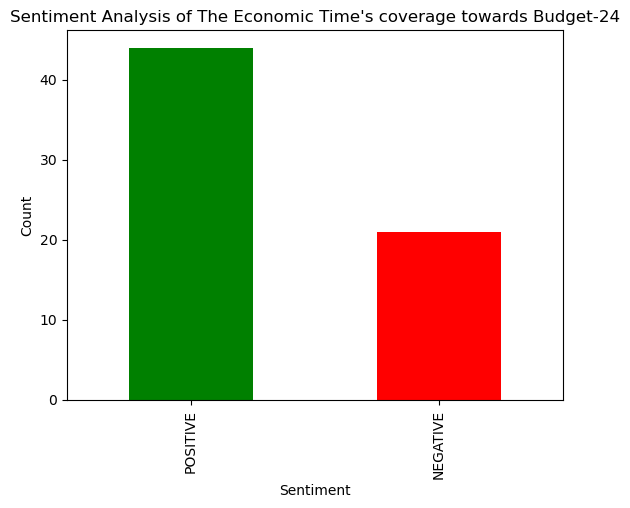

In [20]:
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title("Sentiment Analysis of The Economic Time's coverage towards Budget-24")
plt.show()

# Sentiment Analysis of The Economic Time's Coverage towards Budget-24

## Takeaways:

- The sentiment analysis of The Economic Times' coverage towards Budget-24 reveals a predominance of positive sentiment carrying sentences.
- Approximately 40+ sentences were identified as positive sentiments, indicating a generally favorable stance towards the budget.
- On the other hand, around 20 sentences were classified as carrying negative sentiment, suggesting some areas of concern or criticism within the coverage.

## Outcomes:

- The **overwhelmingly positive sentiment observed** in The Economic Times' coverage towards Budget-24 may indicate a general approval or support for the budgetary measures proposed.
- The presence of negative sentiment carrying sentences highlights areas of potential criticism or concern that may need further attention or clarification.
- Understanding the distribution of sentiment within the coverage can provide valuable insights into the overall reception and impact of Budget-24 as perceived by The Economic Times' readership.
